In [5]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
import cmocean
import rasterio
from rasterio.plot import show

In [6]:
#path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
#ncdf_src = 'BedMachineAntarctica_2020-07-15_v02.nc'

path = 'D:\\3_DataViz\\2_glaciers\\3_ncdf\\'
ncdf_src = 'GLIDATASET_ALPS.nc'

ds = gdal.Open(path+ncdf_src)

for item in ds.GetSubDatasets():
    print (item[0])

HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://errthickness
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://slope
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://stdx
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://stdy
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://thickness
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://vx
HDF5:"D:\3_DataViz\2_glaciers\3_ncdf\GLIDATASET_ALPS.nc"://vy


In [7]:
# Option 1
#thickness = gdal.Open('NETCDF:"/Users/kdruken/Downloads/LS8_OLI_TIRS_NBAR_3577_-10_-28_2013.nc":band_2')

# Option 2 :
#   ds.GetSubDatasets()[7][0] = thickness
src = gdal.Open(ds.GetSubDatasets()[4][0])

print (src.GetMetadata())
print(type(src))


{'Author': 'R. Millan, J. Mouginot, A. Rabatel, M. Morlighem', 'Conventions': 'CF-1.6', 'history': 'Created Tue Apr 20 16:57:31 2021', 'Notes': 'Data were processed at the Institut des Geosciences de l Environnement, Grenoble, France', 'nx': '', 'ny': '', 'proj4': '+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs', 'Projection': 'UTM', 'Title': 'GLacier Ice dynamics DATASET  for ALPS', 'Version': '1.0.0 (August2019)', '_NCProperties': 'version=2,netcdf=4.7.4,hdf5=1.10.6'}
<class 'osgeo.gdal.Dataset'>


In [8]:
# Note GetRasterBand() takes band no. starting from 1 not 0
band = src.GetRasterBand(1)
# set nodata = 0 
band.SetNoDataValue(9.96921e+36)
nodata = band.GetNoDataValue()
arr = band.ReadAsArray()
#Create a masked array for making calculations without nodata values
arr = np.ma.masked_equal(arr, nodata)


In [9]:
 (arr.min(), arr.max(), arr.mean(), arr.std())
#np.sum(np.array(arr) <= 0)

(-14.6640625, 689.0, 55.873072660083714, 73.25361694165535)

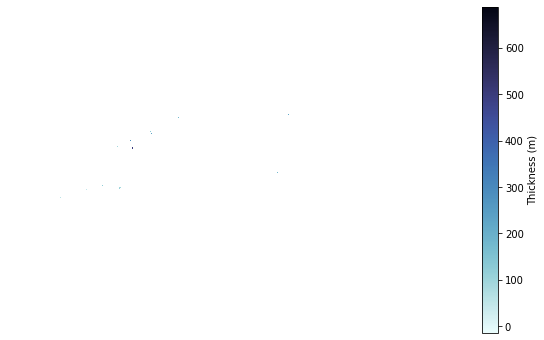

In [10]:
plt.figure(figsize=(10,12))
fig = plt.imshow(arr, origin='lower', cmap=cmocean.cm.ice_r)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#tickval = [1, 10, 100, 100, 500]
#t = np.log(tickval)
cb = plt.colorbar(fig, shrink=0.5)
cb.set_label('Thickness (m)')
#cb.ax.set_yticklabels(tickval)
plt.show()

In [62]:
#normalization du np.array between [0 to 1]
norm_arr =  arr - arr.min() 
norm_arr /= arr.max()-arr.min()


In [63]:
# apply the colormap to dataset
cmap=cmocean.cm.ice_r
rgb_ds = cmap(norm_arr)
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
#Round to the nearest bigger integer
data_array_scaled = np.ceil(data_array_scaled)
data_array_scaled = data_array_scaled.astype(int)
print(data_array_scaled.shape)

(13333, 13333, 4)


In [25]:
 (data_array_scaled.min(), data_array_scaled.max(), data_array_scaled.mean(), data_array_scaled.std())

NameError: name 'data_array_scaled' is not defined

In [1]:
plt.figure(figsize=(10,10))
fig = plt.imshow(data_array_scaled[:,:,2], origin='lower')
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

NameError: name 'plt' is not defined

SetGeoTransform

with (your_top_left_x, pixelWidth, 0, your_top_left_y, 0, -pixelHeight)

Bedmachine Antartica:
    Longitude of true origin: 0°E
    Latitude of true origin : 71°S

https://www.pgc.umn.edu/apps/convert/

y: 3333000

x: -3333000



In [65]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
out_path = 'D:\\3_DataViz\\2_glaciers\\0_Antartica\\'
dest_name = out_path + 'Antarctica_2020-07-15_v02_thickness.tif'

# info from source
originX = -3333000
originY = 3333000 
pixelWidth = int(src.GetMetadata()['spacing'])
pixelHeight = int(src.GetMetadata()['spacing'])
bands = data_array_scaled.shape[2]-1
rows = src.RasterXSize
cols = src.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, -pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(255)


#reprojection (source : http://www2.geog.ucl.ac.uk/~plewis/geogg122_local/geogg122-old/Chapter4_GDAL/GDAL_Python_bindings.html)
proj4_bedmachine = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

destSRS = osr.SpatialReference()
destSRS.ImportFromProj4 (proj4_bedmachine)
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None


reproject : https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon


In [67]:
# add an alpha band to the RGB for transparent background in Mapbox
src_file = path + 'Antarctica_2020-07-15_v02_thickness.tif'
dest_file = path + 'Antarctica_2020-07-15_v02_thickness_rgba.tif'

options = gdal.WarpOptions(format='GTiff', srcNodata=0, dstAlpha=True)
dest = gdal.Warp(dest_file, src_file, options=options)
dest = None

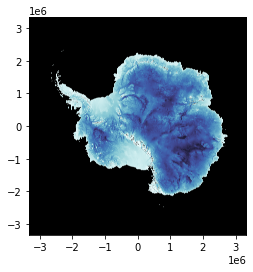

<AxesSubplot:>

In [68]:
fp = path + 'Antarctica_2020-07-15_v02_thickness_rgba.tif'
img = rasterio.open(fp)
show(img)

# reprojection

In [75]:
    ds = path + 'Antarctica_2020-07-15_v02_thickness.tif'
    out_file = path + 'Antarctica_2020-07-15_v02_thickness_3857.tif'
    warp_options = gdal.WarpOptions(dstSRS = 'EPSG:3857')
    gdal.Warp(destNameOrDestDS = out_file, srcDSOrSrcDSTab = ds, options = warp_options)
    print("Processing done for "+out_file)
    ds = None

Processing done for D:\3_DataViz\2_glaciers\0_Antartica\Antarctica_2020-07-15_v02_thickness_3857.tif
